In [1]:
#Import the packages

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Utility Classes

In [4]:
class TrainingData:
    def __init__(self, csv_files):
        self.csv_files = csv_files
        self.db_engine = create_engine('sqlite:///training_data.db')

    def load_data(self):
        for i, csv_file in enumerate(self.csv_files):
            df = pd.read_csv(csv_file)
            df.to_sql(f'training_{i+1}', self.db_engine, if_exists='replace', index=False)

    def calculate_deviation(self, ideal_func):
        deviation = 0.0
        for i, csv_file in enumerate(self.csv_files):
            df = pd.read_sql_table(f'training_{i+1}', self.db_engine)
            y_deviation = df['y1'].subtract(ideal_func(df['x']), fill_value=0)
            deviation += (y_deviation ** 2).sum()
        return deviation

    def select_ideal_functions(self, num_functions):
        """
        Selects the best-fit ideal functions. It iterates a specified number of times, num_functions 
        and in each iteration, it searches for the ideal function with the minimum sum of squared deviations 
        calculated in the calculate_deviation method. The selected function is added to the list of chosen 
        ideal functions.

        """
        ideal_functions = []
        for i in range(num_functions):
            min_deviation = float('inf')
            selected_func = None
            for j in range(50):
                deviation = self.calculate_deviation(self.get_ideal_function(j))
                if deviation < min_deviation:
                    min_deviation = deviation
                    selected_func = self.get_ideal_function(j)
            ideal_functions.append(selected_func)
        return ideal_functions

    def get_ideal_function(self, index):
        """
        Retrieves the actual ideal function based on its index from the "ideal_functions" 
        table in the SQLite database.
        """
        ideal_functions_df = pd.read_sql_table('ideal_functions', self.db_engine)
        func = lambda x: ideal_functions_df.iloc[:, index].loc[ideal_functions_df['x'] == x].values[0]
        return func

In [5]:
class IdealFunctions:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.db_engine = create_engine('sqlite:///training_data.db')

    def load_data(self):
        df = pd.read_csv(self.csv_file)
        df.to_sql('ideal_functions', self.db_engine, if_exists='replace', index=False)


class TestData:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.db_engine = create_engine('sqlite:///training_data.db')

    def load_data(self):
        df = pd.read_csv(self.csv_file)
        df.to_sql('test_data', self.db_engine, if_exists='replace', index=False)
        self.df_test = df

    def map_to_ideal_functions(self, ideal_functions):
        results = []
        for _, row in self.df_test.iterrows():
            x, y = row['x'], row['y']
            max_deviation = sqrt(2) * max(np.abs(ideal_func(x) - y).max() for ideal_func in ideal_functions)
            matched_functions = [i + 1 for i, ideal_func in enumerate(ideal_functions) if
                                  np.abs(ideal_func(x) - y).max() <= max_deviation]
            results.append((x, y, matched_functions, max_deviation))
        df_results = pd.DataFrame(results, columns=['x', 'y', 'Ideal Function', 'Deviation'])
        df_results['x'] = df_results['x'].astype(float)
        df_results['y'] = df_results['y'].astype(float)
        df_results['Ideal Function'] = df_results['Ideal Function'].astype(str)
        df_results['Deviation'] = df_results['Deviation'].astype(float)
        df_results.to_sql('mapped_data', self.db_engine, if_exists='replace', index=False)
    def visualize_data(self):
        df_results = pd.read_sql_table('mapped_data', self.db_engine)

        # Plotting the data points and their deviations
        plt.scatter(df_results['x'], df_results['y'], label='Data Points')
        plt.errorbar(df_results['x'], df_results['y'], yerr=df_results['Deviation'], linestyle='', label='Deviation')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Mapped Data with Deviations')
        plt.legend()
        plt.show()

        

In [6]:
#Loading the files    

In [7]:
training_data = TrainingData(['train.csv'])
training_data.load_data()
ideal_functions = IdealFunctions('Ideal.csv')
ideal_functions.load_data()
test_data = TestData('Test.csv')
test_data.load_data()

In [8]:
#Fitting the training data

In [9]:
chosen_ideal_functions = training_data.select_ideal_functions(4)

In [10]:
#Mapping Ideal Functions

In [11]:
test_data.map_to_ideal_functions(chosen_ideal_functions)

In [12]:
#Visualization

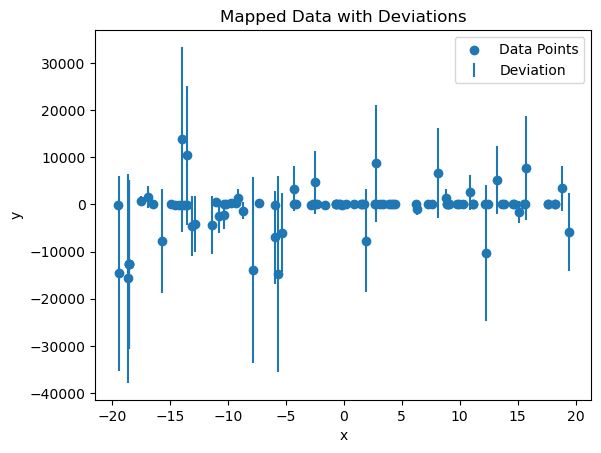

In [13]:
test_data.visualize_data()